In [3]:
%reload_ext autoreload
%autoreload 2

In [1]:
import os
os.chdir('..')
print(os.getcwd())

/Users/davydsadovskyy/GitBackedShit/crypto-prediction


In [9]:
import pandas as pd
import pandas_ta as ta
from src.paths import HISTORICAL_OHLC


df = pd.read_csv(HISTORICAL_OHLC/'ethereum.csv', index_col='Date', parse_dates=True)

def convert_value(value):
    """
    Converts a string value to a float. Removes $ signs, and converts
    billion (bn), million (m), and thousand (K) values to their numeric equivalents.
    """
    value = value.replace('$', '')  # Remove $ sign to simplify processing
    if value[-1].lower() == 'm':
        return float(value[:-1]) * 1_000_000
    elif value[-1].lower() == 'b':
        return float(value[:-1]) * 1_000_000_000
    elif value[-1].lower() == 'k':
        return float(value[:-1]) * 1_000
    elif value[-2:].lower() == 'bn':  # Handle 'bn' for billions
        return float(value[:-2]) * 1_000_000_000
    else:
        return float(value)
columns_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
for column in columns_to_convert:
    df[column] = df[column].apply(lambda x: convert_value(x) if isinstance(x, str) else x)
df['Volume(ETH)'] = pd.to_numeric(df['Volume(ETH)'].apply(lambda x: convert_value(x) if isinstance(x, str) else x), errors='coerce')

df = df.iloc[::-1]
df["TommorowPrice"] = df["Close"].shift(-1)
df["Target"] = (df["TommorowPrice"] > df["Close"]).astype(int)

df


,Open,High,Low,Close,Volume,Volume(ETH),Market Cap,TommorowPrice,Target
Date,,,,,,,,,
2015-08-07,2.8300,3.5400,2.5200,2.7700,1.643000e+05,56374.0,1.753000e+08,0.7533,0
2015-08-08,2.7900,2.8000,0.7147,0.7533,6.742000e+05,382082.0,1.065000e+08,0.7019,0
2015-08-09,0.7061,0.8798,0.6292,0.7019,5.322000e+05,729741.0,4.410000e+07,0.7084,1
2015-08-10,0.7140,0.7299,0.6365,0.7084,4.053000e+05,581293.0,4.210000e+07,1.0700,1
2015-08-11,0.7081,1.1300,0.6632,1.0700,1.500000e+06,1638721.0,5.390000e+07,1.2200,1
...,...,...,...,...,...,...,...,...,...
2024-03-18,3641.0000,3641.0000,3469.0000,3525.0000,1.870000e+10,5241367.0,4.361000e+11,3160.0000,0
2024-03-19,3521.0000,3544.0000,3152.0000,3160.0000,2.930000e+10,8830574.0,4.062000e+11,3512.0000,1
2024-03-20,3166.0000,3528.0000,3067.0000,3512.0000,3.390000e+10,10308565.0,4.023000e+11,3491.0000,0


In [6]:
df

,Open,High,Low,Close,Volume,Volume(ETH),Market Cap,TommorowPrice,Target
Date,,,,,,,,,
2015-08-07,$2.83,$3.54,$2.52,$2.77,$164.3 K,56374.0,$175.3 m,$0.7533,0
2015-08-08,$2.79,$2.80,$0.7147,$0.7533,$674.2 K,382082.0,$106.5 m,$0.7019,0
2015-08-09,$0.7061,$0.8798,$0.6292,$0.7019,$532.2 K,729741.0,$44.1 m,$0.7084,1
2015-08-10,$0.7140,$0.7299,$0.6365,$0.7084,$405.3 K,581293.0,$42.1 m,$1.07,1
2015-08-11,$0.7081,$1.13,$0.6632,$1.07,$1.5 m,1638721.0,$53.9 m,$1.22,1
...,...,...,...,...,...,...,...,...,...
2024-03-18,$3641,$3641,$3469,$3525,$18.7 bn,5241367.0,$436.1 bn,$3160,0
2024-03-19,$3521,$3544,$3152,$3160,$29.3 bn,8830574.0,$406.2 bn,$3512,1
2024-03-20,$3166,$3528,$3067,$3512,$33.9 bn,10308565.0,$402.3 bn,$3491,0


In [ ]:
horizons = [2,5,10,25,50,100] 
predictors = []
for horizon in horizons:
    # Exponential Moving Average (EMA)
    ema_col = f"EMA_{horizon}"
    df[ema_col] = df["Close"] / ta.ema(df["Close"], length=horizon)
    predictors.append(ema_col)
    # Relative Strength Index (RSI)
    rsi_col = f"RSI_{horizon}"
    df[rsi_col] = ta.rsi(df["Close"], length=horizon)
    predictors.append(rsi_col)
    # Simple Moving Average (SMA)
    sma_col = f"SMA_{horizon}"
    df[sma_col] = df["Close"] / ta.sma(df["Close"], length=horizon)
    predictors.append(sma_col)
df = df.dropna()

In [197]:
import pandas as pd

df = pd.read_csv('data/historical_ohlc/ethereum_clean.csv', index_col='Date', parse_dates=True)
df = df.iloc[::-1]
df["TommorowPrice"] = df["Close"].shift(-1)
df["Target"] = (df["TommorowPrice"] > df["Close"]).astype(int)
df

,Open,High,Low,Close,Volume,Volume(ETH),Market Cap,TommorowPrice,Target
Date,,,,,,,,,
2015-08-07,2.8300,3.5400,2.5200,2.7700,1.643000e+05,56374.0,1.753000e+08,0.7533,0
2015-08-08,2.7900,2.8000,0.7147,0.7533,6.742000e+05,382082.0,1.065000e+08,0.7019,0
2015-08-09,0.7061,0.8798,0.6292,0.7019,5.322000e+05,729741.0,4.410000e+07,0.7084,1
2015-08-10,0.7140,0.7299,0.6365,0.7084,4.053000e+05,581293.0,4.210000e+07,1.0700,1
2015-08-11,0.7081,1.1300,0.6632,1.0700,1.500000e+06,1638721.0,5.390000e+07,1.2200,1
...,...,...,...,...,...,...,...,...,...
2024-03-18,3641.0000,3641.0000,3469.0000,3525.0000,1.870000e+10,5241367.0,4.361000e+11,3160.0000,0
2024-03-19,3521.0000,3544.0000,3152.0000,3160.0000,2.930000e+10,8830574.0,4.062000e+11,3512.0000,1
2024-03-20,3166.0000,3528.0000,3067.0000,3512.0000,3.390000e+10,10308565.0,4.023000e+11,3491.0000,0


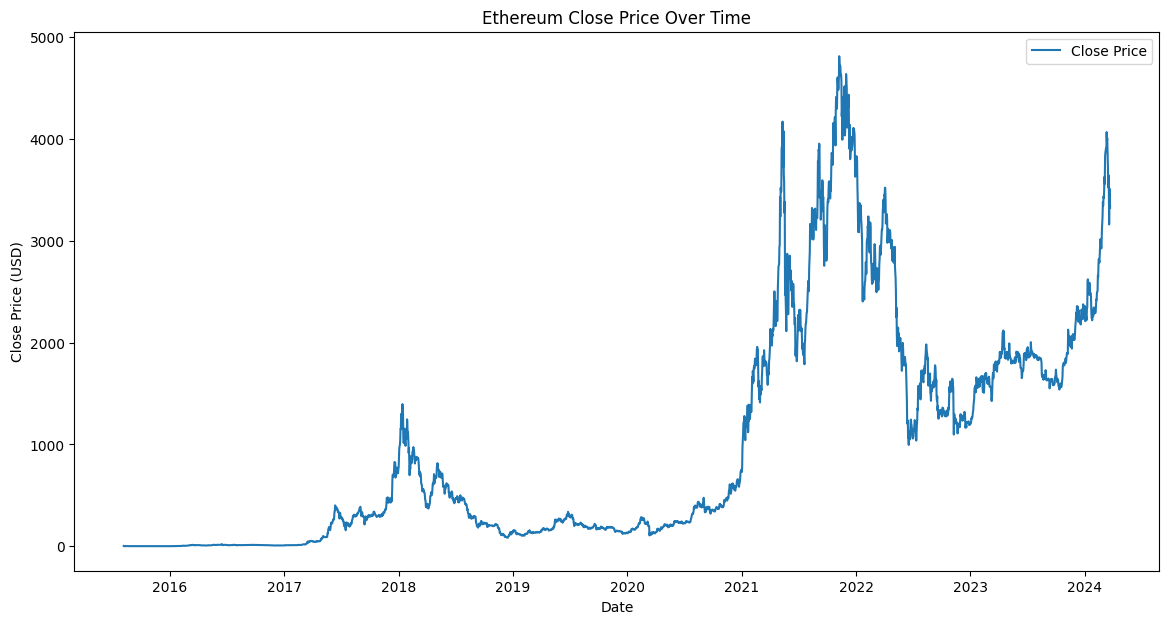

In [198]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it's indexed by Date
# Ensure the index is a DatetimeIndex for proper plotting
df.index = pd.to_datetime(df.index)

plt.figure(figsize=(14, 7))  # Set the figure size for better readability
plt.plot(df.index, df['Close'], label='Close Price')  # Plot the closing prices

plt.title('Ethereum Close Price Over Time')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Close Price (USD)')  # Y-axis label
plt.legend()  # Add a legend

plt.show()  # Display the plot

### If we decided to buy the crypto every day, without using any trading strategy, we would be up 0.502235 of the time.

In [199]:
df["Target"].value_counts() / df.shape[0]

Target
1    0.502235
0    0.497765
Name: count, dtype: float64

In [200]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=2500, step=200):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

### Create new sets of predictors based on momentum of the price, etc, etc

In [201]:
predictors1 = ["Close", "Open", "Volume", "Volume(ETH)", "High", "Low"]

predictors2 = ["Volume(ETH)"]

predictors3 = []
df3 = df.copy()
horizons = [2,5,10,25,50,100] 
for horizon in horizons:
    rolling_averages = df3.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    df3[ratio_column] = df3["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    df3[trend_column] = df3.shift(1).rolling(horizon).sum()["Target"]

    predictors3 += [ratio_column, trend_column]
df3 = df3.dropna()

In [202]:
df3["Target"].value_counts() / df3.shape[0]

Target
1    0.505114
0    0.494886
Name: count, dtype: float64

In [238]:
import pandas_ta as ta

df4 = df.copy()
horizons = [2,5,10,25,50,100] 

predictors4 = []

for horizon in horizons:

    # Exponential Moving Average (EMA)
    ema_col = f"EMA_{horizon}"
    df4[ema_col] = df4["Close"] / ta.ema(df4["Close"], length=horizon)
    predictors4.append(ema_col)
    
    # Relative Strength Index (RSI)
    rsi_col = f"RSI_{horizon}"
    df4[rsi_col] = ta.rsi(df4["Close"], length=horizon)
    predictors4.append(rsi_col)

    # # MOM
    # mom_col = f"MOM_{horizon}"
    # df4[mom_col] = ta.mom(df4["Close"], length=horizon)
    # predictors4.append(mom_col)
    
    # Simple Moving Average (SMA)
    sma_col = f"SMA_{horizon}"
    df4[sma_col] = df4["Close"] / ta.sma(df4["Close"], length=horizon)
    predictors4.append(sma_col)

df4 = df4.dropna()


In [243]:
predictors4

['EMA_2',
 'RSI_2',
 'SMA_2',
 'EMA_5',
 'RSI_5',
 'SMA_5',
 'EMA_10',
 'RSI_10',
 'SMA_10',
 'EMA_25',
 'RSI_25',
 'SMA_25',
 'EMA_50',
 'RSI_50',
 'SMA_50',
 'EMA_100',
 'RSI_100',
 'SMA_100']

In [235]:
predictors5 = ["RSI_2", "RSI_3", "RSI_4", "RSI_5"]
predictors5 = ["RSI_4"]

In [240]:
df4["Target"].value_counts() / df4.shape[0]

Target
1    0.505114
0    0.494886
Name: count, dtype: float64

In [242]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

# n_estimators: nubmer of individual decision trees to train
# min_samples_split: helps protect against overfit. The higher it is, the less accurate model will be, but will overfit less.
# So... lower min_samples_split = higher complexity, smaller bias, higher variance
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

predictions = backtest(df4, model, predictors4)

# precision score: when we said the market would go up (target score = 1), did it actually go up. 
# precision = True positive / sum(predicted positive column)
precision_score(predictions["Target"], predictions["Predictions"])

0.5423728813559322